In [1]:
from os import walk
import socket
if socket.gethostname() == 'jim-Mint':
    ppi_path = '/home/jim/src/p39/fftanalysis/test_systems'
    home = '/home/jim'
elif socket.gethostname() == 'host252.ent.iit.edu':
    ppi_path = '/home/jtufts/Downloads/test_systems'
    home = '/home/jtufts'
elif socket.gethostname() == 'pandora':
    # ppi_path = '/home/jtufts/src/p39/fftanalysis/test_systems'
    ppi_path = '/mnt/fft/FFT_PPI'
    home = '/home/jtufts'
else:
    ppi_path = '/home/jtufts/src/p39/fftanalysis/test_systems'
    home = '/home/jtufts'

In [2]:
f = {}
for (dirpath, dirnames, filenames) in walk(f'{ppi_path}/2.redock/2.minimize'):
    if len(filenames) > 0:
        if filenames[0] != 'run_me.sh':
            if 'ligand.inpcrd' in filenames:
                # f[dirpath.split('/')[9]] = dirpath + '/ligand.inpcrd'
                f[dirpath.split('/')[6]] = dirpath + '/ligand.inpcrd'

In [15]:
keys = list(f.keys())
keys.sort()
system = keys[127] #36 #8
print(system, f[system])

2OOB_A:B /mnt/fft/FFT_PPI/2.redock/2.minimize/2OOB_A:B/ligand.inpcrd


In [17]:
from bpmfwfft.IO import InpcrdLoad
from bpmfwfft.grids import Grid, RecGrid
import numpy as np


def _distance(coord1, coord2):
    assert len(coord1)==len(coord1)==3, "coord must have len 3"
    d = np.array(coord1) - np.array(coord2)
    d = (d**2).sum()
    return np.sqrt(d)


def _max_inter_atom_distance(inpcrd):
    """
    inpcrd: str, name of inpcrd file
    """
    crd = InpcrdLoad(inpcrd).get_coordinates()
    max_d = 0.
    for i in range(crd.shape[0]-1):
        for j in range(i+1, crd.shape[0]):
            d = _distance(crd[i], crd[j])
            if d > max_d:
                max_d = d
    return max_d


def _max_box_edge(inpcrd):
    """
    """
    crd = InpcrdLoad(inpcrd).get_coordinates()
    dx = crd[:,0].max() - crd[:,0].min()
    dy = crd[:,1].max() - crd[:,1].min()
    dz = crd[:,2].max() - crd[:,2].min()
    return max([dx, dy, dz])


def rec_grid_cal(prmtop, lj_scale, sc_scale, ss_scale, sm_scale, rho,
                 rec_inpcrd, lig_inpcrd, spacing, buffer,
                 grid_out, pdb_out, box_out, radii_type, exclude_H):
    """
    prmtop: str, prmtop file for receptor
    lj_scale:   float, 0 < lj_scale <=1
    rc_scale:   float, 0 < rc_scale
    rs_scale:   float, 0 < rs_scale
    rm_scale:   float, 0 < rm_scale
    rec_inpcrd: str, inpcrd file for receptor
    lig_inpcrd: str, inpcrd file for ligand, used to determine grid size
    spacing:    float, distance between grid points in Angstroms
    buffer:     float, extra box padding
    grid_out:   str, name of output nc file
    pdb_out:    str, name of output pdb file
    box_out:    str, name of output box
    radii_type: str, name of radii to use, LJ_SIGMA or VDW_RADII
    exclude_H:  bool, exclude hydrogen from grid calculation
    """
    #ligand_max_size = _max_inter_atom_distance(lig_inpcrd)
    #print "Ligand maximum inter-atomic distance: %f"%ligand_max_size

    ligand_max_box_edge = _max_box_edge(lig_inpcrd)
    print("Ligand maximum box edge: %f" % ligand_max_box_edge)
    total_buffer = np.ceil(ligand_max_box_edge + buffer)
    print("Total buffer for receptor grid: %f" % total_buffer)

    bsite_file = None
    potential_grid = RecGrid(prmtop,
                             lj_scale,
                             sc_scale,
                             ss_scale,
                             sm_scale,
                             rho,
                             rec_inpcrd,
                             bsite_file,
                             grid_out,
                             new_calculation=True,
                             spacing=spacing,
                             extra_buffer=total_buffer,
                             radii_type=radii_type,
                             exclude_H=exclude_H)
    # potential_grid = RecGrid(prmtop, lj_scale, sc_scale, ss_scale, rho, rec_inpcrd, bsite_file, grid_out, new_calculation=True, spacing=spacing, )

    potential_grid.write_pdb(pdb_out, "w")
    potential_grid.write_box(box_out)

    return None


def is_nc_grid_good(nc_grid_file):
    if not os.path.exists(nc_grid_file):
        return False

    if os.path.getsize(nc_grid_file) == 0:
        return False

    nc_handle = netCDF4.Dataset(nc_grid_file, "r")
    nc_keys = nc_handle.variables.keys()
    grid_keys = Grid().get_allowed_keys()
    for key in grid_keys:
        if key not in nc_keys:
            return False
    return True


def get_grid_size_from_nc(grid_nc_file):
    nc_handle = netCDF4.Dataset(grid_nc_file, "r")
    return nc_handle.variables["counts"][0]


def get_grid_size_from_lig_rec_crd(rec_inpcrd, lig_inpcrd, buffer):
    ligand_max_box_edge = _max_box_edge(lig_inpcrd)
    buffer_due_to_ligand = np.ceil(ligand_max_box_edge + buffer)
    box_size = _max_box_edge(rec_inpcrd) +  2.0*buffer_due_to_ligand
    return box_size

In [18]:
prmtop = f"{ppi_path}/2.redock/1.amber/{system}/receptor.prmtop"
lj_scale = 1.0
rc_scale = 0.76
rs_scale = 0.53
rm_scale = 0.55
rec_inpcrd = f"{ppi_path}/2.redock/2.minimize/{system}/receptor.inpcrd"
lig_inpcrd = f"{ppi_path}/2.redock/2.minimize/{system}/ligand.inpcrd"
rho = 9.0
exclude_H = True

spacing = 0.50
buffer = 1
radii_type = "VDW_RADII"

grid_out = f"{ppi_path}/2.redock/4.receptor_grid/{system}/grid.nc"
pdb_out = f"{ppi_path}/2.redock/4.receptor_grid/{system}/receptor_trans.pdb"
box_out = f"{ppi_path}/2.redock/4.receptor_grid/{system}/box.pdb"

rec_grid_cal(prmtop, lj_scale, rc_scale, rs_scale, rm_scale, rho,
             rec_inpcrd, lig_inpcrd, spacing, buffer, grid_out, pdb_out, box_out, radii_type, exclude_H)

Number of atoms in /mnt/fft/FFT_PPI/2.redock/2.minimize/2OOB_A:B/ligand.inpcrd is 777
Ligand maximum box edge: 34.376128
Total buffer for receptor grid: 36.000000
[1.]
Number of atoms in /mnt/fft/FFT_PPI/2.redock/2.minimize/2OOB_A:B/receptor.inpcrd is 1231
Writing lj_sigma_scaling_factor into nc file
Writing rec_core_scaling into nc file
Writing rec_surface_scaling into nc file
Writing rec_metal_scaling into nc file
Writing rho into nc file
Writing molecule_sasa into nc file
No binding site specified, box encloses the whole receptor
[0. 0. 0.]
[0.5 0.  0. ]
[0.  0.5 0. ]
[0.  0.  0.5]
[0.5 0.5 0.5]
Receptor enclosing box [34.993732, 33.049136, 34.502023]
extra_buffer: 36.000000
[215 215 215]
counts  [215 215 215]
Total box size 107.000000
Writing origin into nc file
Writing d0 into nc file
Writing d1 into nc file
Writing d2 into nc file
Writing spacing into nc file
Writing counts into nc file
calculating grid coordinates
[  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.

In [19]:
%%time
import netCDF4 as nc
import numpy as np
grid_name = "grid.nc"
grid_path = f'{ppi_path}/2.redock/4.receptor_grid/{system}'
print(grid_path)
grid_nc = '%s/%s'%(grid_path,grid_name)


#parsing some of the netcdf variables from grid.nc
grid_variables = nc.Dataset(grid_nc, 'r').variables
counts = nc.Dataset(grid_nc, 'r').variables["counts"][:]
x = nc.Dataset(grid_nc, 'r').variables["x"][:]
y = nc.Dataset(grid_nc, 'r').variables["y"][:]
z = nc.Dataset(grid_nc, 'r').variables["z"][:]
electrostatic = nc.Dataset(grid_nc, 'r').variables["electrostatic"][:]
lja = nc.Dataset(grid_nc, 'r').variables["LJa"][:]
ljr = nc.Dataset(grid_nc, 'r').variables["LJr"][:]
sasa = nc.Dataset(grid_nc, 'r').variables["sasa"][:]
occupancy = nc.Dataset(grid_nc, 'r').variables["occupancy"][:]
trans_crd = nc.Dataset(grid_nc, 'r').variables["trans_crd"][:]
rec_disp = nc.Dataset(grid_nc, 'r').variables["displacement"][:]

/mnt/fft/FFT_PPI/2.redock/4.receptor_grid/2OOB_A:B
CPU times: user 51.7 ms, sys: 70.8 ms, total: 122 ms
Wall time: 122 ms


In [20]:
%%time
from bpmfwfft.grids import RecGrid
from bpmfwfft.grids import LigGrid
import netCDF4 as nc

rec_prmtop = f"{ppi_path}/2.redock/1.amber/{system}/receptor.prmtop"
lj_sigma_scal_fact = 1.0
rec_inpcrd = f"{ppi_path}/2.redock/2.minimize/{system}/receptor.inpcrd"

bsite_file = None
grid_nc_file = f"{ppi_path}/2.redock/4.receptor_grid/{system}/grid.nc"

lig_prmtop = f"{ppi_path}/2.redock/1.amber/{system}/ligand.prmtop"
# lig_inpcrd = f"{ppi_path}/2.redock/2.minimze/2OOB_A:B/ligand.inpcrd"

# rot_nc = f"{ppi_path}/2.redock/3.ligand_rand_rot/{system}/trajectory.nc"
# lig_rot = nc.Dataset(rot_nc, 'r').variables['positions']
lig_inpcrd = f"{ppi_path}/2.redock/2.minimize/{system}/ligand.inpcrd"

rho = 9.0
rc_scale = 0.76
rs_scale = 0.53
rm_scale = 0.55
lc_scale = 0.81
ls_scale = 0.50
lm_scale = 0.54


def _create_rec_grid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, grid_nc_file):
    rec_grid = RecGrid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, 
                        grid_nc_file, new_calculation=False)
    return rec_grid

def _create_lig_grid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid):
    lig_grid = LigGrid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid)
    return lig_grid

rec_grid = _create_rec_grid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, grid_nc_file)

lig_grid = _create_lig_grid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid)
# rot_num = 0
# lig_grid._crd = np.array(lig_rot[rot_num], dtype=np.float64)
lig_grid._move_ligand_to_lower_corner()

[1.]
/mnt/fft/FFT_PPI/2.redock/4.receptor_grid/2OOB_A:B/grid.nc
x
[  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5
  12.   12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5
  18.   18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5
  24.   24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5
  30.   30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5
  36.   36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5
  42.   42.5  43.   43.5  44.   44.5  45.   45.5  46.   46.5  47.   47.5
  48.   48.5  49.   49.5  50.   50.5  51.   51.5  52.   52.5  53.   53.5
  54.   54.5  55.   55.5  56.   56.5  57.   57.5  58.   58.5  59.   59.5
  60.   60.5  61.   61.5  62.   62.5  63.   63.5  64.   64.5  65.   65.5
  66.   66.5  67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.   71.5
  72.   72.5  73.   73.5  74.   74.5  75.   75.5  76.   76

In [21]:
names = ["occupancy", "sasa", "electrostatic", "LJa", "LJr", "water"]

In [22]:
%%time
# names = ["occupancy", "LJa", "LJr"]
# names = ["LJr", "LJa", "occupancy"]
lgrid = lig_grid.get_ligand_grids(names, [0,0,0])
# vect = [91,90,120]*lig_grid._spacing
# lgrid = lig_grid.get_ligand_grids(names, vect)

calculating Ligand occupancy grid
--- occupancy calculated in 1.1369884014129639 seconds ---
calculating Ligand sasa grid
--- sasa calculated in 3.174328565597534 seconds ---
calculating Ligand electrostatic grid
--- electrostatic calculated in 1.089026927947998 seconds ---
calculating Ligand LJa grid
--- LJa calculated in 1.1412301063537598 seconds ---
calculating Ligand LJr grid
--- LJr calculated in 1.0819616317749023 seconds ---
calculating Ligand water grid
--- water calculated in 1.6527249813079834 seconds ---
CPU times: user 4.02 s, sys: 3.57 s, total: 7.58 s
Wall time: 9.3 s


In [ ]:
lig_grid._move_ligand_to_lower_corner()
lgrid2 = lig_grid.get_ligand_grids(names, np.array([69.5,69,0]))

In [17]:
np.array([139,138,0])*lig_grid._spacing[0]

array([69.5, 69. ,  0. ])

In [27]:
print(lgrid["LJr"].sum(), lgrid["LJa"].sum())

695270.4934885271 14559.341346165513


In [28]:
print(lgrid["LJr"].sum(), lgrid["LJa"].sum())

695270.4934885271 14559.341346165513


In [35]:
# direct grid pairwise multiplication vs fft energy test
print(np.sum(lgrid["LJr"]*ljr))

lljr_fft = np.fft.fftn(lgrid["LJr"])
rljr_fft = rec_grid._FFTs["LJr"]
ljr_energy = np.fft.ifftn(rljr_fft * lljr_fft.conjugate())
ljr_energy = np.real(ljr_energy)
print(ljr_energy[0,0,0])
print(ljr_energy[91,90,120])

print(np.where(ljr_energy == ljr_energy.min()))

l_occ = np.fft.fftn(lgrid["occupancy"]).conjugate()
r_occ = rec_grid._FFTs["occupancy"]
occ = np.fft.ifftn(r_occ * l_occ)
occ = np.real(occ)

native = (rec_disp-lig_grid._displacement)#/lig_grid._spacing[0]
print(native)
occ_x, occ_y, occ_z = (native/lig_grid._spacing[0]).astype(int)
print([occ_x, occ_y, occ_z], occ[occ_x, occ_y, occ_z], ljr_energy[occ_x, occ_y, occ_z])
print(rec_disp,lig_grid._displacement, rec_disp-lig_grid._displacement)

2.8935136279409288e-09
3.0581789214176524e-09
23363.916262583243
(array([183]), array([159]), array([79]))
[44.  40.  14.5]
[88, 80, 29] -1.7883614426984805e-13 130.70173841267376
[52. 28. 34.] [  8.  -12.   19.5] [44.  40.  14.5]


In [46]:
print(np.min(ljr), lgrid["LJr"].min())
print(lig_grid._prmtop.keys())
print(lig_grid._prmtop["R_LJ_CHARGE"].max())
print((np.array(np.where(lgrid["LJr"] < -30.0)).T)*lig_grid._spacing)
di = []
for acrd in lig_grid._crd:
    d = _distance(acrd, np.array([71.5,58.5,83.5]))
    if d < 2.0:
        di.append(np.array(np.where(lig_grid._crd == acrd)).T[0][0])
print(di)
print(lig_grid._prmtop["PDB_TEMPLATE"].keys())
for id in di:
    print(lig_grid._prmtop["PDB_TEMPLATE"]["ATOM_NAME"][id], lig_grid._prmtop["R_LJ_CHARGE"][id])
cai = [index for index, value in enumerate(lig_grid._prmtop["PDB_TEMPLATE"]["ATOM_NAME"]) if value == 'CA']
print(lig_grid._prmtop["R_LJ_CHARGE"][136])
print(cai)
print(np.where(lig_grid._prmtop["R_LJ_CHARGE"]<1))
print(lig_grid._prmtop["PDB_TEMPLATE"]["ATOM_NAME"][774])
for index in [0,4,50,52,9,10,60,112,62,112,193,199]:
    print(lig_grid._prmtop["PDB_TEMPLATE"]["ATOM_NAME"][index] , lig_grid._prmtop["R_LJ_CHARGE"][index], lig_grid._crd[index]) 
print(lig_grid._prmtop["R_LJ_CHARGE"].mean())

1.5332537699165151e-18 0.0
dict_keys(['CHARGE_E_UNIT', 'R_LJ_CHARGE', 'A_LJ_CHARGE', 'LJ_SIGMA', 'LJ_EPSILON', 'VDW_RADII', 'POINTERS', 'MASS', 'PDB_TEMPLATE'])
2047.9999999999986
[]
[]
dict_keys(['ATOM_NAME', 'RES_NAME', 'RES_ORDER'])
1021.3129931612534
[4, 19, 25, 40, 50, 60, 79, 94, 108, 124, 136, 146, 168, 187, 197, 219, 238, 255, 262, 277, 284, 305, 315, 335, 350, 365, 381, 403, 427, 437, 456, 471, 490, 500, 517, 531, 545, 561, 576, 592, 602, 626, 637, 656, 675, 699, 714, 734, 744, 772]
(array([  1,   2,   3,  24,  39,  49,  59,  78,  93, 102, 103, 107, 123,
       135, 145, 161, 162, 163, 167, 186, 196, 212, 213, 214, 218, 237,
       254, 261, 276, 283, 296, 304, 314, 334, 349, 364, 380, 396, 397,
       398, 402, 415, 418, 419, 421, 422, 426, 436, 455, 470, 489, 499,
       511, 512, 516, 525, 526, 530, 539, 540, 544, 560, 575, 591, 601,
       614, 617, 618, 620, 621, 625, 632, 636, 655, 674, 687, 690, 691,
       693, 694, 698, 713, 733, 743]),)
C
N 971.7475150469897 [66.1743

In [11]:
# calculate FFTs and scoring functions for each grid type
llja_fft = np.fft.fftn(lgrid["LJa"])
rlja_fft = rec_grid._FFTs["LJa"]
lljr_fft = np.fft.fftn(lgrid["LJr"])
rljr_fft = rec_grid._FFTs["LJr"]
l_occ = np.fft.fftn(lgrid["occupancy"]).conjugate()
r_occ = rec_grid._FFTs["occupancy"]
el_fft = np.fft.fftn(lgrid["electrostatic"])
er_fft = rec_grid._FFTs["electrostatic"]
sasal_fft = np.fft.fftn(lgrid["sasa"])
sasar_fft = rec_grid._FFTs["sasa"]
waterl_fft = np.fft.fftn(lgrid["water"])
waterr_fft = rec_grid._FFTs["water"]
occ = np.fft.ifftn(r_occ * l_occ)
occ = np.real(occ)
lja_energy = np.fft.ifftn(rlja_fft * llja_fft.conjugate())
lja_energy = np.real(lja_energy)
ljr_energy = np.fft.ifftn(rljr_fft * lljr_fft.conjugate())
ljr_energy = np.real(ljr_energy)
elec_energy = np.fft.ifftn(er_fft * el_fft.conjugate())
elec_energy = np.real(elec_energy)
dsr_energy = np.fft.ifftn(sasar_fft * waterl_fft.conjugate())
dsr_energy = np.real(dsr_energy)
dsl_energy = np.fft.ifftn(waterr_fft * sasal_fft.conjugate())
dsl_energy = np.real(dsl_energy)
ds_energy = dsr_energy+dsl_energy*0.005

KeyError: 'electrostatic'

In [49]:
# analyze poses from above
print(lja_energy[occ_x, occ_y, occ_z], ljr_energy[occ_x, occ_y, occ_z], occ[occ_x, occ_y, occ_z], elec_energy[occ_x, occ_y, occ_z], ds_energy[occ_x, occ_y, occ_z])
print(lja_energy[140,139,0], ljr_energy[140,139,0], occ[140,139,0], elec_energy[140,139,0], ds_energy[140,139,0])

-177.04101638945536 130.70173841267376 -1.7883614426984805e-13 75.50660953293118 3.522191019733826
-0.010395251723186122 9.909290377240722e-10 2.5338173076990862e-14 197.1203343480466 -3.179737389959231e-17


In [56]:
lig_grid._prmtop["CHARGE_E_UNIT"].min()

-0.9406999994512218

In [28]:
max_i, max_j, max_k = lig_grid._max_grid_indices
lig_grid._free_of_clash = (occ < 0.001)
lig_grid._free_of_clash = lig_grid._free_of_clash[0:max_i, 0:max_j, 0:max_k]

In [29]:
lig_grid._meaningful_energies = np.zeros(lig_grid._grid["counts"], dtype=float)
if np.any(lig_grid._free_of_clash):
    grid_func_energy = np.fft.ifftn(rlja_fft * llja_fft.conjugate())
    grid_func_energy = np.real(grid_func_energy)
    lig_grid._meaningful_energies += grid_func_energy

In [10]:
def rmsd(P: np.ndarray, Q: np.ndarray, **kwargs) -> float:
    """
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    Parameters
    ----------
    V : array
        (N,D) matrix, where N is points and D is dimension.
    W : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        Root-mean-square deviation between the two vectors
    """
    diff = P - Q
    return np.sqrt((diff * diff).sum() / P.shape[0])

In [11]:
# nnls based charges
# LJa Min:-2004.92 LJa Max: -0.00
# LJr Min:0.00   LJr Max: 2470.44

# score = lig_grid._meaningful_energies
score = lja_energy
score2 = ljr_energy
print(f"LJa Min:{np.amin(score):.2f}", f"LJa Max: {np.amax(score):.2f}")
print(f"LJr Min:{np.amin(score2):.2f}", f"  LJr Max: {np.amax(score2):.2f}")
k = 2000 # number of scores to save
flat_score = score.flatten()
flat_argp = np.argpartition(flat_score, k)[:k]
flat_score2 = score2.flatten()
flat_argp2 = np.argpartition(flat_score2, -k)[-k:]

LJa Min:-52549.86 LJa Max: 160.99
LJr Min:-566432.85   LJr Max: 17170270.91


In [12]:
import copy
lig_grid._move_ligand_to_lower_corner()
lig_grid.translate_ligand(np.array([65, 85, 43])*lig_grid._spacing)
ref = copy.deepcopy(lig_grid._crd)
lig_grid._move_ligand_to_lower_corner()
# lig_grid.translate_ligand(np.array([5,5,5])*lig_grid._spacing)
# tar = copy.deepcopy(lig_grid._crd)

# print("rmsd", rmsd(ref, tar))

Ligand translated by [0. 0. 0.]
[2.0160512 1.9921129 2.0055658]
Ligand translated by [-16.25 -21.25 -10.75]
[2.0160512 1.9921129 2.0055658]


In [13]:
def cat_grids(grid1, grid2):
    prmtop = cat_dictionaries(grid1._prmtop,grid2._prmtop)
    crd = cat_dictionaries(grid1._crd,grid2._crd)
    cat_grid = copy.deepcopy(grid1)
    cat_grid._prmtop = prmtop
    cat_grid._crd = crd
    return cat_grid

def cat_dictionaries(dict1, dict2):
    dict1_copy = copy.deepcopy(dict1)
    dict2_copy = copy.deepcopy(dict2)
    
    if isinstance(dict1_copy, dict):
        keys = list(dict1_copy.keys())
        for key in keys:
            # print(keys)
            # print(key)
            dict1_copy[key] = cat_values(dict1[key], dict2[key])
        return dict1_copy
    
    elif isinstance(dict1_copy, np.ndarray):
        return np.concatenate((dict1_copy,dict2_copy))

def cat_values(a1, a2):
    array1 = copy.deepcopy(a1)
    array2 = copy.deepcopy(a2)
    if isinstance(array1, np.ndarray):
        return np.concatenate((array1,array2))
    elif isinstance(array1, dict):
        return cat_dictionaries(array1, array2)
    elif isinstance(array1, (int, np.int64)):
        # print(f"{array1+array2}")
        return array1 + array2
    elif isinstance(array1, list):
        # print(type(array1))
        # print(f'array1:{len(array1)}, array2:{len(array2)}')
        array1.extend(array2)
        # print(f'complex:{len(array1)}, sum:{len(a1)+len(a2)}')
        return array1

In [14]:
# for small molecule and ligand testing
# x = np.zeros(int(12/lig_grid._spacing[0]))
# y = np.zeros(int(12/lig_grid._spacing[0]))
# x[:] = 4.625/lig_grid._spacing[0]
# y[:] = 4.625/lig_grid._spacing[0]
# z = np.arange(0, int(12/lig_grid._spacing[0]), 1)
# test_range = np.stack([x,y,z],1)

# for crystal pose for proteins
native_trans = (rec_disp-lig_grid._displacement)
print(native_trans, native_trans/lig_grid._spacing[0])
x = np.zeros(int(5/lig_grid._spacing[0]))
y = np.zeros(int(5/lig_grid._spacing[0]))
x[:] = native_trans[0]/lig_grid._spacing[0]
y[:] = native_trans[1]/lig_grid._spacing[0]
z = np.arange((native_trans[2]/lig_grid._spacing[0])-15, (native_trans[2]/lig_grid._spacing[0])+5, 1)
test_range = np.stack([x,y,z],1)
print(test_range)

[33.75 43.5  22.25] [135.0 174.0 89.0]
[[135. 174.  74.]
 [135. 174.  75.]
 [135. 174.  76.]
 [135. 174.  77.]
 [135. 174.  78.]
 [135. 174.  79.]
 [135. 174.  80.]
 [135. 174.  81.]
 [135. 174.  82.]
 [135. 174.  83.]
 [135. 174.  84.]
 [135. 174.  85.]
 [135. 174.  86.]
 [135. 174.  87.]
 [135. 174.  88.]
 [135. 174.  89.]
 [135. 174.  90.]
 [135. 174.  91.]
 [135. 174.  92.]
 [135. 174.  93.]]


In [15]:
# 4ε[(σ/r)^12 - (σ/r)^6]
def lj_components(receptor, ligand):
    """
    Accepts a ligand and receptor grid and calculates the LJa and LJr terms and the overall LJ Potential
    receptor    RecGrid
    ligand      LigGrid
    """
    ljr_energy, lja_energy, lj_energy = c_lj_components(receptor._crd, ligand._crd, receptor._prmtop["LJ_EPSILON"], ligand._prmtop["LJ_EPSILON"], receptor._prmtop["LJ_SIGMA"], ligand._prmtop["LJ_SIGMA"])

    return ljr_energy.sum(), lja_energy.sum(), lj_energy.sum()

# 4ε[(σ/r)^12 - (σ/r)^6]
def lj_components_old(receptor, ligand):
    """
    Accepts a ligand and receptor grid and calculates the LJa and LJr terms and the overall LJ Potential
    receptor    RecGrid
    ligand      LigGrid
    """
    r_natoms = receptor.get_natoms()
    l_natoms = ligand.get_natoms()
    ljr_energy = np.zeros((r_natoms, l_natoms))
    lja_energy = np.zeros((r_natoms, l_natoms))
    lj_energy = np.zeros((r_natoms, l_natoms))
    
    for i in range(r_natoms):
        for j in range(l_natoms):
            eps = np.sqrt(receptor._prmtop["LJ_EPSILON"][i]*ligand._prmtop["LJ_EPSILON"][j])
            sigma = np.mean([receptor._prmtop["LJ_SIGMA"][i], ligand._prmtop["LJ_SIGMA"][j]])
            # sigma = np.sqrt(receptor._prmtop["LJ_SIGMA"][i]*ligand._prmtop["LJ_SIGMA"][j])
            ljr = (4*eps)*(sigma/_distance(rec_grid._crd[i], lig_grid._crd[j]))**12
            lja = -(4*eps)*(sigma/_distance(rec_grid._crd[i], lig_grid._crd[j]))**6
            ljr_energy[i,j] = ljr
            lja_energy[i,j] = lja
            lj_energy[i,j] = ljr+lja
    return ljr_energy.sum(), lja_energy.sum(), lj_energy.sum()

In [16]:
%load_ext cython

In [17]:
%%cython

import numpy as np
cimport numpy as np

cdef extern from "math.h":
    double sqrt(double)

def cdistance(np.ndarray[np.float64_t, ndim=1] x, np.ndarray[np.float64_t, ndim=1] y):
    cdef int i, lmax
    cdef double d, tmp
    lmax = x.shape[0]
    d = 0.
    for i in range(lmax):
        tmp = x[i] - y[i]
        d += tmp*tmp
    return sqrt(d)

# 4ε[(σ/r)^12 - (σ/r)^6]
def c_lj_components(np.ndarray[np.float64_t, ndim=2] crd_a,
                    np.ndarray[np.float64_t, ndim=2] crd_b,
                    np.ndarray[np.float64_t, ndim=1] a_epsilon,
                    np.ndarray[np.float64_t, ndim=1] b_epsilon,
                    np.ndarray[np.float64_t, ndim=1] a_sigma,
                    np.ndarray[np.float64_t, ndim=1] b_sigma):
    cdef: 
        int a_natoms = crd_a.shape[0]
        int b_natoms = crd_b.shape[0]
        int i,j = 0
        double lja, ljr = 0.
        double eps, sigma = 0.
        np.ndarray[np.float64_t, ndim=2] ljr_energy = np.zeros((a_natoms, b_natoms))
        np.ndarray[np.float64_t, ndim=2] lja_energy = np.zeros((a_natoms, b_natoms))
        np.ndarray[np.float64_t, ndim=2] lj_energy = np.zeros((a_natoms, b_natoms))
        double[:,:] crd_a_view = crd_a
        double[:,:] crd_b_view = crd_b
        double[:] a_eps_view = a_epsilon
        double[:] b_eps_view = b_epsilon
        double[:] a_sig_view = a_sigma
        double[:] b_sig_view = b_sigma
        
    for i in range(a_natoms):
        for j in range(b_natoms):
            eps = sqrt(a_epsilon[i]*b_epsilon[j])
            sigma = (a_sig_view[i]+b_sig_view[j])/2.
            ljr = (4*eps)*(sigma/cdistance(crd_a[i], crd_b[j]))**12
            lja = -(4*eps)*(sigma/cdistance(crd_a[i], crd_b[j]))**6
            ljr_energy[i,j] = ljr
            lja_energy[i,j] = lja
            lj_energy[i,j] = ljr+lja
    return ljr_energy, lja_energy, lj_energy
            
            

In [18]:
import copy
import time
# result = map(cat_dictionaries, rec_grid._prmtop, lig_grid._prmtop)
delta_sasas = []
colors = []
output = []
distances = -1*z*lig_grid._spacing[0]+21.5
a_energies = []
da_energies = []
r_energies = []
dr_energies = []
potentials = []
ljr_actual = []
lja_actual = []
lj_actual = []
start_time = time.time()
for v,vector in enumerate(test_range):
    print(f"start loop: {time.time()-start_time}s")
    vector_crd = (np.array(vector).transpose()*lig_grid._spacing[0])
    vector = vector.astype(int)
    dx,dy,dz = vector
    lig_grid._move_ligand_to_lower_corner()
    print(vector, vector_crd)
    lig_grid.translate_ligand(vector_crd)
    com_grid = cat_grids(rec_grid, lig_grid)
    rmsd_to_native = rmsd(ref, lig_grid._crd)
    if rmsd_to_native < 5.:
        # colors.append([255, 0, 0])
        colors.append("red")
    else:
        # colors.append([0, 255, 255])
        colors.append("black")
    num = str(vector[2]).replace(".", "_")
    com_grid.write_pdb(f'{home}/src/p39/fftanalysis/test_systems/3.analysis/1.pdbs/{system}/complex/complex_{vector[2]:03}.pdb', "w")
    lig_grid.write_pdb(f'{home}/src/p39/fftanalysis/test_systems/3.analysis/1.pdbs/{system}/ligand/trans{vector[2]:03}.pdb', "w")
    rec_grid.write_pdb(f'{home}/src/p39/fftanalysis/test_systems/3.analysis/1.pdbs/{system}/receptor/rec.pdb', "w")
    print(f"write files: {time.time()-start_time}s")
    # if rec_grid._crd.mean(axis=0)[2] > lig_grid._crd.mean(axis=0)[2]:
    #     distances.append(_distance(lig_grid._crd.mean(axis=0),rec_grid._crd.mean(axis=0)))
    # else:
    #     distances.append(-1*(_distance(lig_grid._crd.mean(axis=0),rec_grid._crd.mean(axis=0))))
    print(f"append fft energies: {time.time()-start_time}s")
    a_energies.append(lja_energy[dx,dy,dz])
    r_energies.append(ljr_energy[dx,dy,dz])
    potentials.append(lja_energy[dx,dy,dz]+ljr_energy[dx,dy,dz])
    charges = lig_grid.get_charges()
    lja_charge = charges["A_LJ_CHARGE"]
    ljr_charge = charges["R_LJ_CHARGE"]
    e_charges = charges["CHARGE_E_UNIT"]
    zeros = np.zeros(lja_charge.shape)
    lja_charges = {"A_LJ_CHARGE": lja_charge, "R_LJ_CHARGE": zeros, "CHARGE_E_UNIT": zeros}
    ljr_charges = {"A_LJ_CHARGE": zeros, "R_LJ_CHARGE": ljr_charge, "CHARGE_E_UNIT": zeros}
    print(f"append direct energies: {time.time()-start_time}s")
    # dr_energies.append(rec_grid.direct_energy(lig_grid._crd, ljr_charges))
    # da_energies.append(rec_grid.direct_energy(lig_grid._crd, lja_charges))
    # oljr, olja, olj = lj_components_old(rec_grid, lig_grid)
    # dr_energies.append(oljr)
    # da_energies.append(olja)
    dr_energies.append(0)
    da_energies.append(0)
    print(f"start lj components: {time.time()-start_time}s")
    a,b,c = lj_components(rec_grid, lig_grid)
    print(f"end lj components: {time.time()-start_time}s")
    ljr_actual.append(a)
    lja_actual.append(b)
    lj_actual.append(c)
    # output.append(f"Distance: {_distance(lig_grid._crd[0],rec_grid._crd[0]):.1f} Angstroms, LJa Energy: grid: {lja_energy[dx,dy,dz]:.5f} direct: {da_energies[-1]:.5f}, LJr Energy: grid: {ljr_energy[dx,dy,dz]:.5f} direct: {dr_energies[-1]:.5f}, LJ Potential: {lja_energy[dx,dy,dz]+ljr_energy[dx,dy,dz]:.5f}")
    output.append(f"Distance: {_distance(lig_grid._crd[0],rec_grid._crd[0]):.1f} Angstroms, LJa Energy: grid: {lja_energy[dx,dy,dz]:.5f} direct: {da_energies[-1]:.5f}, LJr Energy: grid: {ljr_energy[dx,dy,dz]:.5f} direct: {dr_energies[-1]:.5f}, LJ Potential: {lja_energy[dx,dy,dz]+ljr_energy[dx,dy,dz]:.5f}")
for line in output:
    print(line)

start loop: 0.00025534629821777344s
Ligand translated by [0. 0. 0.]
[2.0160512 1.9921129 2.0055658]
[135 174  74] [33.75 43.5  18.5 ]
write files: 0.8578426837921143s
append fft energies: 0.8578898906707764s
append direct energies: 0.8579022884368896s
start lj components: 0.8579061031341553s
end lj components: 10.620893001556396s
start loop: 10.621182680130005s
Ligand translated by [-33.75 -43.5  -18.5 ]
[2.0160512 1.9921129 2.0055658]
[135 174  75] [33.75 43.5  18.75]
write files: 11.488965511322021s
append fft energies: 11.489015340805054s
append direct energies: 11.489028692245483s
start lj components: 11.48903226852417s
end lj components: 21.156701803207397s
start loop: 21.156996965408325s
Ligand translated by [-33.75 -43.5  -18.75]
[2.0160512 1.9921129 2.0055658]
[135 174  76] [33.75 43.5  19.  ]
write files: 22.024910926818848s
append fft energies: 22.024962186813354s
append direct energies: 22.024976015090942s
start lj components: 22.02497959136963s
end lj components: 31.6707627

In [19]:
def get_sigmas(grid):
    values= np.unique(grid._prmtop["LJ_SIGMA"])
    return values
    

def add_vertical_lines(x_values):
    for ind,x in enumerate(x_values):
        plt.axvline(x=x, linestyle='--')
        plt.text(x + 0.1, ind + 2, f"{x:.2f}", rotation=0, verticalalignment='center')

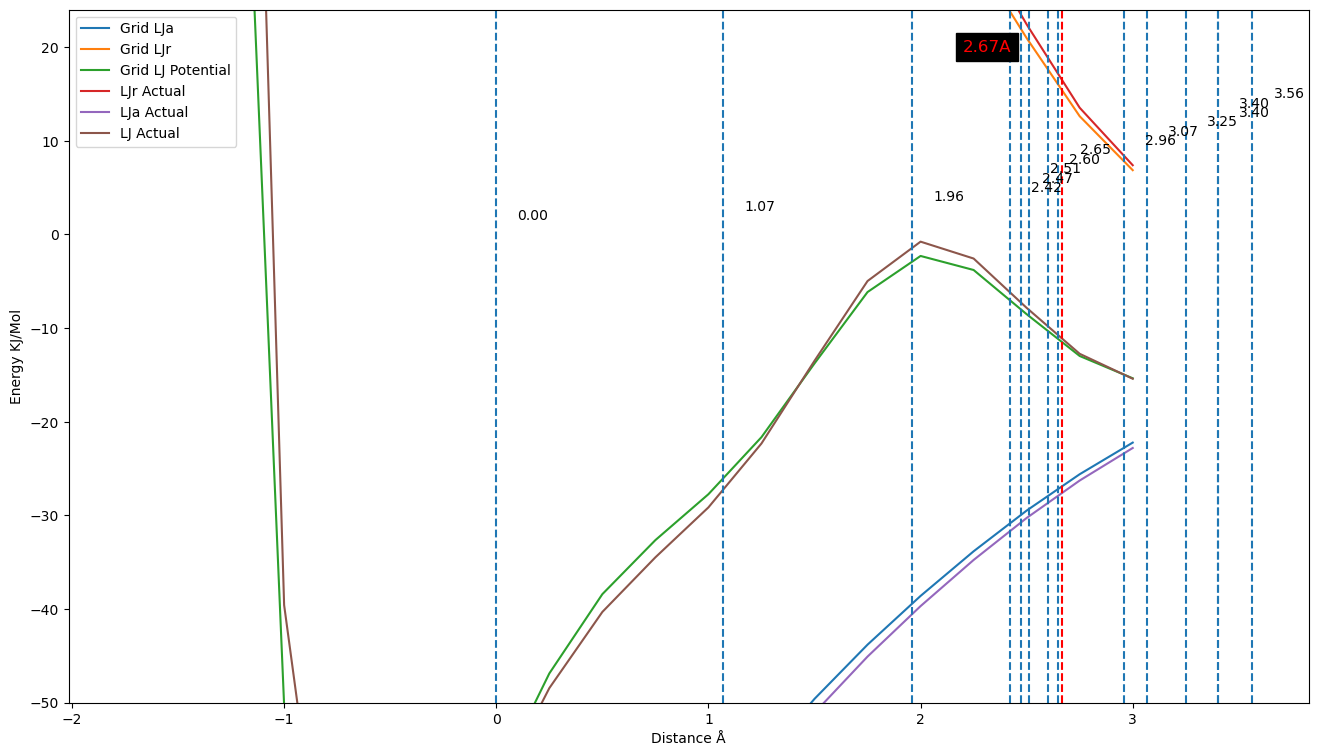

In [20]:
import matplotlib.pyplot as plt
d_potentials = [sum(x) for x in zip(da_energies, dr_energies)]
plt.figure(figsize=(16,9))
cut = 0
plt.plot(distances, a_energies, label="Grid LJa")
plt.plot(distances, r_energies, label="Grid LJr")
# plt.plot(distances, da_energies, label="Direct LJa")
# plt.plot(distances, dr_energies, label="Direct LJr")
plt.plot(distances, potentials, label="Grid LJ Potential")
# plt.plot(distances, d_potentials, label="Direct LJ Potential")
plt.plot(distances[cut:], ljr_actual[cut:], label="LJr Actual")
plt.plot(distances[cut:], lja_actual[cut:], label="LJa Actual")
plt.plot(distances, lj_actual, label="LJ Actual")
add_vertical_lines(get_sigmas(rec_grid))
plt.xlabel("Distance Å")
plt.ylabel("Energy KJ/Mol")
plt.ylim(-50,24)
plt.axvline(x=2.6666947806561088, linestyle='--', color='red')
plt.text(2.2, 20, f"{2.666:.2f}A", rotation=0, verticalalignment='center', color="red", backgroundcolor="black", size=12)
plt.legend()
plt.show()

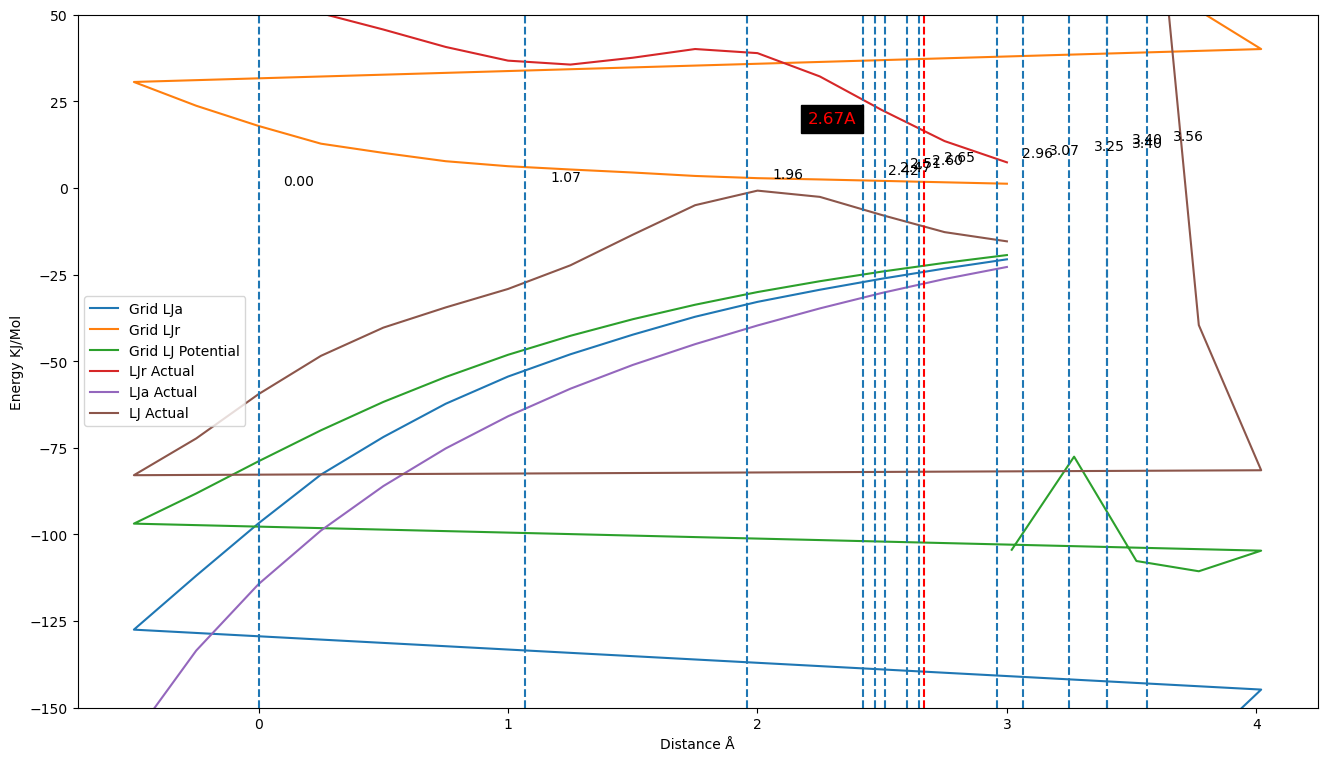

In [28]:
import matplotlib.pyplot as plt
d_potentials = [sum(x) for x in zip(da_energies, dr_energies)]
plt.figure(figsize=(16,9))
cut = 0
plt.plot(distances_adjusted, a_energies, label="Grid LJa")
plt.plot(distances_adjusted, r_energies, label="Grid LJr")
# plt.plot(distances_adjusted, da_energies, label="Direct LJa")
# plt.plot(distances_adjusted, dr_energies, label="Direct LJr")
plt.plot(distances_adjusted, potentials, label="Grid LJ Potential")
# plt.plot(distances_adjusted, d_potentials, label="Direct LJ Potential")
plt.plot(distances_adjusted[cut:], ljr_actual[cut:], label="LJr Actual")
plt.plot(distances_adjusted[cut:], lja_actual[cut:], label="LJa Actual")
plt.plot(distances_adjusted, lj_actual, label="LJ Actual")
add_vertical_lines(get_sigmas(rec_grid))
plt.xlabel("Distance Å")
plt.ylabel("Energy KJ/Mol")
plt.ylim(-150,50)
plt.axvline(x=2.6666947806561088, linestyle='--', color='red')
plt.text(2.2, 20, f"{2.666:.2f}A", rotation=0, verticalalignment='center', color="red", backgroundcolor="black", size=12)
plt.legend()
plt.show()

In [21]:
dist_approved = -1*z*lig_grid._spacing[0]+21.5

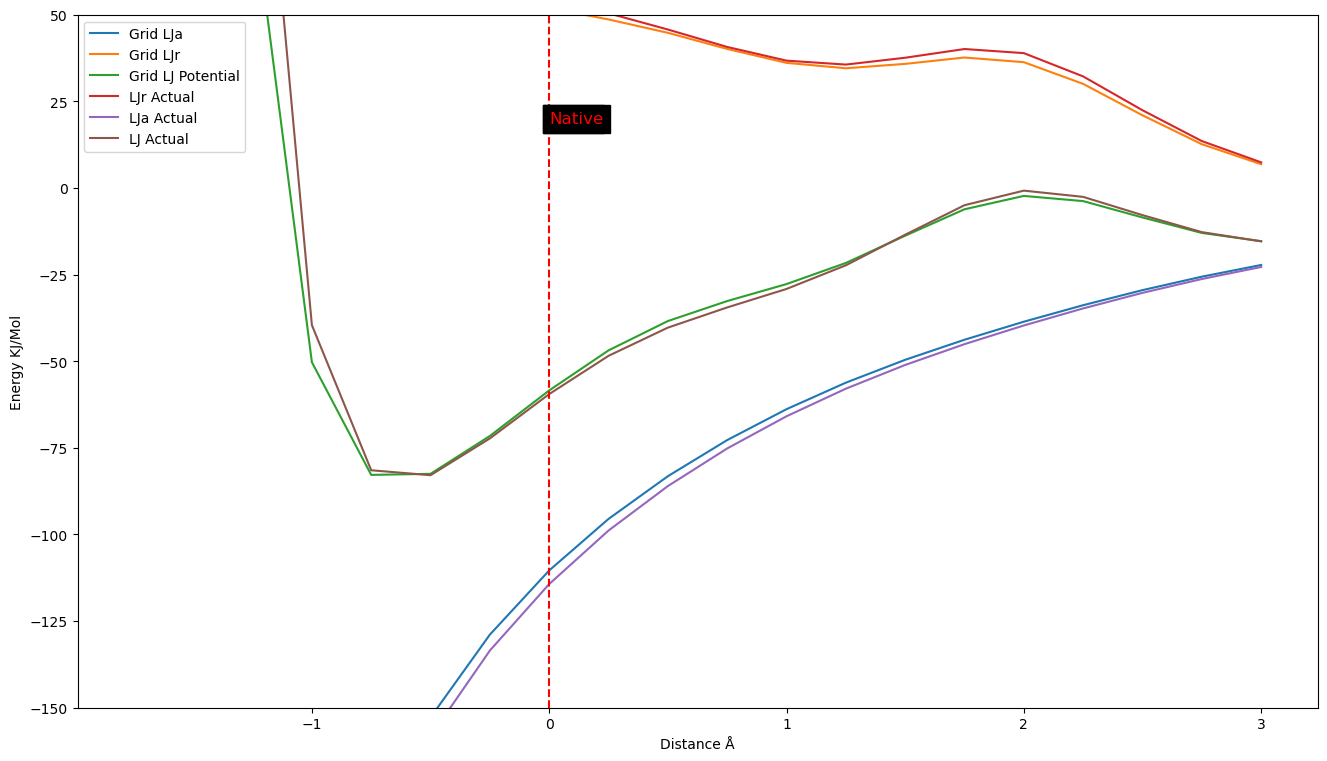

In [23]:
import matplotlib.pyplot as plt
d_potentials = [sum(x) for x in zip(da_energies, dr_energies)]
plt.figure(figsize=(16,9))
cut = 0
plt.plot(dist_approved, a_energies, label="Grid LJa")
plt.plot(dist_approved, r_energies, label="Grid LJr")
# plt.plot(dist_approved, da_energies, label="Direct LJa")
# plt.plot(dist_approved, dr_energies, label="Direct LJr")
plt.plot(dist_approved, potentials, label="Grid LJ Potential")
# plt.plot(dist_approved, d_potentials, label="Direct LJ Potential")
plt.plot(dist_approved[cut:], ljr_actual[cut:], label="LJr Actual")
plt.plot(dist_approved[cut:], lja_actual[cut:], label="LJa Actual")
plt.plot(dist_approved, lj_actual, label="LJ Actual")
# add_vertical_lines(get_sigmas(rec_grid))
plt.xlabel("Distance Å")
plt.ylabel("Energy KJ/Mol")
plt.ylim(-150,50)
plt.axvline(x=0, linestyle='--', color='red')
plt.text(0, 20, f"{2.666:.2f}A", rotation=0, verticalalignment='center', color="red", backgroundcolor="black", size=12)
plt.text(0, 20, f"Native", rotation=0, verticalalignment='center', color="red", backgroundcolor="black", size=12)
plt.legend()
plt.savefig('/home/jtufts/LA_solver.png')
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
add_vertical_lines(get_sigmas(rec_grid))

In [23]:
def write_lig_dx(FN, data, grid):
    """
    Writes a grid in dx format
    """
    n_points = data['counts'][0] * data['counts'][1] * data['counts'][2]
    if FN.endswith('.dx'):
        F = open(FN, 'w')

    F.write("""object 1 class gridpositions counts {0[0]} {0[1]} {0[2]}
origin {1[0]} {1[1]} {1[2]}
delta {2[0]} 0.0 0.0
delta 0.0 {2[1]} 0.0
delta 0.0 0.0 {2[2]}
object 2 class gridconnections counts {0[0]} {0[1]} {0[2]}
object 3 class array type double rank 0 items {3} data follows
""".format(data['counts'], data['origin'], data['spacing'], n_points))

    for start_n in range(0, len(grid.ravel()), 3):
        F.write(' '.join(['%6e' % c
                        for c in grid.ravel()[start_n:start_n + 3]]) + '\n')

    F.write('object 4 class field\n')
    F.write('component "positions" value 1\n')
    F.write('component "connections" value 2\n')
    F.write('component "data" value 3\n')
    F.close()

In [24]:
def write(FN, data, grid, multiplier=None):
    """
    Writes a grid in dx or netcdf format.
    The multiplier affects the origin and spacing.
    """
    if multiplier is not None:
      data_n = {
        'origin': multiplier * data['origin'],
        'counts': data['counts'],
        'spacing': multiplier * data['spacing'],
        'vals': grid
      }
    else:
      data_n = data
    if FN.endswith('.nc'):
        print('skip')
#       _write_nc(FN, data_n)
    elif FN.endswith('.dx') or FN.endswith('.dx.gz'):
      write_lig_dx(FN, data_n, grid)
    else:
      raise Exception('File type not supported')

In [25]:
import bpmfwfft.IO as IO
data = {"origin": lig_grid._grid['origin'], "spacing": lig_grid._spacing, "counts": lig_grid._grid["counts"]}
FN=f"{ppi_path}/2.redock/4.receptor_grid/{system}/rec_electrostatic_grid.dx"
write(FN, data, electrostatic)

In [49]:
print(lig_grid._crd.min(axis=0), rec_grid._crd.max(axis=0))

[35.8910512 45.6171129 23.3805658] [69.5144563 68.5886631 69.5205898]


In [43]:
lig_grid._crd.max(axis=0)

array([70.2671795, 67.1065984, 54.911315 ])

In [51]:
lig_grid._crd[34]

array([64.6702199, 56.5483709, 48.8178034])

In [50]:
rec_grid._crd[107]

masked_array(data=[63.0950694, 58.3378962, 48.8729138],
             mask=False,
       fill_value=1e+20)

In [85]:
native_trans

masked_array(data=[32.5, 42.5, 21.5],
             mask=False,
       fill_value=1e+20)

In [109]:
z

array([28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
       41., 42., 43., 44., 45., 46., 47.])

In [25]:
distances_adjusted = np.concatenate([np.array(distances)[:15],2.384646106485934+np.array(distances)[15:]+2.384646106485934])

In [26]:
distances_adjusted

array([ 3.        ,  2.75      ,  2.5       ,  2.25      ,  2.        ,
        1.75      ,  1.5       ,  1.25      ,  1.        ,  0.75      ,
        0.5       ,  0.25      ,  0.        , -0.25      , -0.5       ,
        4.01929221,  3.76929221,  3.51929221,  3.26929221,  3.01929221])

In [99]:
z

array([26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45.])

In [40]:
dist_approved

array([ 3.  ,  2.75,  2.5 ,  2.25,  2.  ,  1.75,  1.5 ,  1.25,  1.  ,
        0.75,  0.5 ,  0.25,  0.  , -0.25, -0.5 , -0.75, -1.  , -1.25,
       -1.5 , -1.75])

In [17]:
import numpy as np
a = np.array([-4.90426079e+03, -4.81116080e+03, -4.68872621e+03,  1.09770556e+06,
       -1.87029767e+03, -4.80533684e+03, -3.46392124e+03,  5.14701435e+04,
       -3.63506137e+03, -4.80240066e+03,  1.70692048e+06, -4.31121681e+03,
       -4.61844768e+03, -1.29523935e+03, -4.16333979e+03,  2.66633396e+07,
       -4.56449582e+03,  3.70037204e+03, -4.44168745e+03,  8.27422853e+04,
       -2.67374636e+03, -4.80382752e+03, -4.70733530e+03, -1.59482350e+03,
        2.21975125e+06, -4.78570737e+03,  6.56348559e+05,  8.56324815e+04,
        3.86711816e+06,  8.15004047e+06,  6.79018187e+05,  4.03537568e+04,
        1.19402895e+06,  7.80222203e+08,  6.97123861e+08,  1.05272700e+05,
        5.10737899e+07, -3.93464595e+03, -4.92084225e+03, -4.76127482e+03,
        1.45218251e+04,  1.99994267e+03, -1.50027795e+03,  2.06020361e+06,
        1.96716035e+04,  1.60379747e+07,  2.27186172e+06, -4.90089985e+03,
        1.67254065e+05,  2.26206754e+03,  1.12171531e+04,  6.03264714e+07,
        1.50195804e+05,  5.39531994e+03,  5.81092291e+05, -4.70634623e+03,
        6.67062523e+06, -4.84474768e+03,  9.05885102e+04,  6.01742600e+04,
        3.01547440e+06,  7.00201930e+00,  1.63157458e+05,  3.49266120e+05,
        1.98075451e+03,  1.74885199e+05, -2.69791549e+03,  8.71699878e+08,
       -3.76326058e+03,  1.36444137e+06, -3.34181689e+03,  8.27710709e+04,
        2.80397775e+04,  5.75751664e+04, -4.06777700e+03, -4.83987183e+03,
       -4.87115532e+03,  3.56164756e+07,  7.20227640e+05,  5.20348844e+03,
        3.34187908e+04,  2.27872082e+04,  1.47116273e+04,  4.49279573e+04,
        1.05702463e+04,  3.59917835e+05,  8.13298694e+03,  1.66471099e+03,
        2.67674140e+04,  4.55107529e+06,  3.28121079e+05,  1.00571628e+04,
        2.02494388e+06,  7.97112214e+03,  4.66874897e+04,  8.81562539e+04,
        1.59374252e+04, -2.73027244e+03,  4.39462950e+04,  1.12722444e+05,
        4.11260533e+05,  2.91434121e+03,  3.38502419e+04,  7.07029597e+03,
        1.52920440e+05,  1.26904987e+05,  8.09442446e+05, -4.89661158e+03,
        8.66417231e+04,  4.74480919e+07,  2.52428457e+08,  1.82470335e+03,
        2.99490591e+08,  2.48029377e+04,  4.50555252e+04,  8.22845224e+05,
        2.10468481e+04,  2.06621125e+06,  7.87440493e+03,  1.73162407e+05,
        7.20675085e+05,  8.39605471e+03, -1.39538435e+03,  5.20605045e+06,
        2.97351835e+04,  2.84246057e+03,  3.32388309e+05,  2.37912976e+04,
       -3.24118250e+03,  6.53910643e+06,  2.07387116e+04,  2.81835523e+06,
       -3.27871627e+03,  8.83394309e+04,  2.58745219e+07,  8.37525135e+02,
        3.13350629e+04,  7.92746102e+05,  1.20158098e+08, -4.43827700e+03,
        6.71727598e+04,  1.72522836e+06, -4.83014683e+03,  1.96161599e+14,
        1.92699704e+06,  7.89110621e+11, -4.75541296e+03,  2.90264189e+04,
        1.52822219e+07,  6.45509547e+05,  1.85287957e+04,  9.46804039e+03,
        3.32919073e+05,  7.72600764e+05,  1.23917188e+05,  6.63274151e+04,
        6.80178662e+04,  2.87102503e+07,  4.55296790e+03,  2.88074534e+05,
       -4.86907534e+03, -4.76502449e+03,  1.11099456e+07,  1.33918200e+06,
       -4.03250872e+03,  5.42739890e+05,  5.68484073e+05,  2.77946900e+05,
        7.78398540e+05, -8.52455065e+02, -2.63777594e+03,  2.68061268e+05,
        8.76850831e+10,  2.32802824e+07,  7.65927695e+07, -4.74464431e+03,
        3.54388692e+03, -4.79164377e+03,  7.65249914e+03,  3.57782553e+06,
        1.93362752e+05,  1.12714323e+05,  2.19063697e+06,  8.34365637e+05,
        2.14943969e+04,  1.38243054e+04,  9.89430690e+04,  1.50682992e+07,
        7.47433516e+05,  4.20343873e+10,  4.51122417e+04,  1.92141273e+06,
        4.91652691e+04, -3.52298235e+03,  2.39909833e+05,  2.90369333e+02,
        1.08571313e+04,  7.49331428e+05,  4.04998758e+07,  4.70879368e+07,
        6.93293814e+05,  1.52823446e+06,  1.28516576e+05,  3.58301386e+05,
        7.50713995e+05,  7.87901260e+08,  3.71520514e+04,  2.83194944e+05,
        4.39724157e+05,  2.73213986e+06, -4.71847520e+03,  7.74512322e+08,
       -4.74036960e+03,  7.85878536e+03,  1.52879280e+06,  7.28898196e+05,
       -6.75856182e+01,  4.28608654e+05,  1.07864796e+04,  1.30574052e+04,
        8.63361692e+06,  5.36277977e+04,  1.00780630e+05, -4.79664905e+03,
        1.39259974e+11,  1.50918362e+06,  7.17922003e+05, -1.21066540e+03,
        2.30141729e+04,  1.80172786e+07, -1.31297434e+03,  1.07394858e+05,
        6.84765168e+04,  4.73760383e+07,  2.65128663e+06,  4.25238036e+08,
        5.41147938e+05,  9.07705600e+04,  3.95508809e+04,  7.40848329e+03,
        1.02436369e+07,  4.62197905e+06, -4.03275619e+03,  5.57482565e+03,
        7.95407199e+11,  1.04401991e+05,  1.23918195e+04,  1.39367284e+07,
        2.68090300e+04,  5.58609031e+05,  1.10124669e+04,  3.34883827e+06,
        4.18830464e+03, -7.64153816e+02,  2.89403005e+04,  2.61606741e+04,
        4.78388335e+04,  1.07161094e+05,  5.85587397e+05,  8.81462657e+06,
        3.37706399e+04,  3.90089438e+04,  3.01019998e+04,  4.88894720e+05,
        1.33691595e+06,  8.40473722e+04,  8.87575909e+07,  1.94704260e+06,
        6.23426035e+05,  4.95008062e+03,  6.19985659e+05,  2.29174002e+03,
        6.55891500e+07, -3.53384385e+03,  6.51903846e+06, -3.91949453e+03,
        2.23603732e+03,  4.88722525e+03, -2.47634157e+03,  5.98559745e+04,
       -4.42577926e+03,  6.91242180e+08,  9.70169241e+04, -4.41109184e+03,
        6.32519787e+03, -2.10562971e+03,  8.37099117e+02,  2.32668135e+05,
        1.29364553e+14,  4.66404299e+08, -7.78024153e+02,  5.05816005e+03,
        1.86778043e+05,  7.50287348e+04,  1.42725319e+03,  1.07502668e+04,
        1.96188632e+05,  3.57687051e+04,  8.49022824e+06, -3.40466740e+03,
        2.57064118e+05,  3.19774036e+04,  2.15339109e+05,  9.36633847e+05,
        2.27451942e+09, -3.25361282e+03,  2.03617393e+07,  9.80352152e+06,
        2.60787262e+08,  1.39663165e+06, -4.29407572e+03,  4.89080823e+04,
        1.36056993e+04,  2.09680406e+03, -4.54066445e+03,  4.44869330e+04,
        3.73654813e+05,  1.19704463e+06,  1.69336669e+05,  5.39498748e+04,
        4.26695562e+04,  1.09247326e+06,  2.46783757e+03, -4.87140499e+03,
        1.99374172e+05,  1.06894700e+06,  2.61065117e+03,  4.81344806e+08,
        6.16668423e+06,  6.20764805e+05, -6.72633989e+02,  9.79377182e+03,
        1.85876336e+03,  5.58097748e+05,  9.48172709e+03, -3.35223634e+03,
        7.63440825e+05,  9.60878993e+05,  1.19814431e+06,  1.83141486e+04,
        8.36532097e+06,  6.71292906e+07,  3.15755830e+07,  2.26317158e+07,
        1.47307153e+04,  4.97619225e+07, -1.46417170e+02,  1.70338401e+05,
        7.49807994e+04,  1.50320229e+05,  1.41178661e+06,  3.81186497e+05,
        3.57702642e+05,  3.29718247e+06,  2.92558416e+06,  5.80209094e+05,
       -4.83482027e+03,  1.45975323e+05,  3.49292103e+04,  4.14919856e+04,
        3.03281386e+06,  4.77934181e+04,  4.99327818e+04,  7.80220858e+05,
        4.57265833e+05,  1.62464217e+07,  1.37291040e+06,  2.39511193e+05,
       -4.60452784e+03,  2.40138451e+07,  5.53822182e+05,  8.56279334e+05,
        3.46839066e+08,  2.23660918e+04,  1.99413538e+06,  1.26106757e+07,
        5.17439746e+09,  8.34090003e+06,  2.86358500e+07,  2.20326708e+08,
        3.28188587e+06,  1.58694888e+06,  8.35419825e+07,  3.08652156e+04,
        7.33651584e+06,  1.60342945e+05,  3.25242433e+06,  2.62955737e+03,
        5.93501790e+06,  4.80825228e+05,  3.14727044e+05,  1.34257311e+07,
       -4.19014807e+03,  3.71312513e+06, -2.31181278e+03,  5.49662664e+04,
        2.29552033e+06,  3.68188915e+08,  1.79577265e+05, -4.86671006e+03,
       -2.48328118e+03,  1.34455400e+08,  1.18166491e+06,  5.45554169e+04,
        5.70594222e+07,  6.44166784e+06,  9.21781695e+03,  1.21420379e+04,
        4.21401597e+04,  2.30255521e+08,  6.44861830e+03,  1.96347837e+05,
        7.11934261e+04,  3.77304651e+07,  2.46866975e+08,  1.74149453e+05,
        4.55012196e+07,  1.74845734e+06,  6.06830110e+03,  1.52822685e+04,
        3.71904770e+06,  1.18271378e+04,  1.34976085e+05,  5.70445965e+06,
       -2.08925267e+03,  2.54403355e+11,  9.20855492e+04, -4.71639731e+03,
        8.21196229e+04,  1.10828061e+05,  2.70881227e+04,  1.08414501e+06,
        2.89051127e+05,  7.01227981e+05,  1.92069483e+05, -1.06858376e+03,
        1.85138947e+07, -1.21785860e+03,  5.46297387e+03,  5.31806507e+06,
        9.55538477e+06,  3.42952819e+04,  4.48677264e+04,  4.73880292e+06,
        1.92063583e+05,  4.94699326e+05,  7.44438175e+04,  5.71466366e+06,
        1.78756047e+04,  2.58081831e+04, -1.32203622e+03,  1.36477561e+08,
        1.32137250e+04, -3.63693786e+03,  6.55523004e+06,  3.93548991e+03,
        4.40132921e+03, -4.53164027e+03,  1.35916529e+06,  1.09324433e+05,
        9.61770075e+06,  8.96078303e+04, -4.75220233e+03,  6.45309298e+04,
        1.13235200e+05, -2.71393581e+03,  7.41270377e+06,  1.16094866e+05,
        1.80798357e+04,  3.59876234e+05, -2.25599952e+03,  4.64554947e+05,
        6.43529124e+03, -4.83564685e+03,  3.14471808e+04,  6.63745192e+04,
        5.27258463e+06,  3.62657138e+04,  6.69128796e+04,  5.36052275e+04,
        4.80469747e+06,  2.77623281e+08,  2.03012707e+04,  1.32466057e+04,
       -1.89529272e+03,  3.90859186e+05,  5.14414203e+05,  6.30938695e+04,
        3.98950689e+05,  2.00908737e+06,  1.06314172e+04,  4.61513319e+06,
        7.91554707e+04,  1.45767642e+04,  3.75209694e+04, -3.01851096e+03,
        2.65641910e+07,  2.51113657e+06,  2.04250457e+07,  3.23628292e+03,
        1.16099479e+06,  3.65573291e+04,  2.48819645e+11,  8.03236040e+04,
       -2.53607348e+03,  1.15742679e+05,  5.97374570e+05,  5.27944161e+06,
       -3.01424109e+03,  4.18778854e+04,  3.09447002e+06, -4.20649173e+03,
        1.93048450e+04,  5.26484564e+04,  5.07372847e+06,  1.52339202e+08,
       -4.47420997e+03,  1.18898762e+04,  4.60579660e+04,  2.33136222e+03,
        2.80446560e+06,  9.76406356e+05,  1.30035348e+05,  1.79552493e+05,
        1.09010305e+04,  1.73498460e+03,  1.30317213e+09,  1.68225283e+04,
        1.37015348e+06,  3.74546218e+03,  1.22143837e+08,  2.87654896e+03,
       -3.45540481e+03,  9.07824382e+06,  3.92182065e+04,  2.23263651e+03,
        7.99113452e+05,  1.55343442e+07,  2.72404043e+05, -3.80504193e+03,
        8.10974503e+03,  1.62027356e+05,  4.19069544e+07,  4.24293982e+04,
        2.25908167e+04,  1.08970059e+07,  2.15273095e+06,  2.85798757e+09,
        1.43726162e+02,  1.44186179e+05, -3.44574867e+03,  1.40331282e+04,
        1.50203363e+04,  3.08676012e+04,  1.18199748e+08,  2.79558237e+05,
       -4.40937893e+03, -2.35665573e+03,  2.44691058e+04,  1.46204655e+07,
        1.42531495e+06,  1.10255794e+05,  5.25163263e+04,  1.15833498e+05,
        7.12424980e+05,  2.04908788e+04,  6.64960578e+07,  6.23290174e+03,
        1.88991943e+06,  6.67475434e+04, -3.42000707e+03,  3.76246839e+05,
        6.53829990e+04,  5.55032002e+04,  8.57876588e+03, -3.14179538e+03,
        4.96420184e+08,  1.09781346e+07,  1.23057990e+12,  8.29699437e+06,
        2.89389300e+03,  2.32803035e+06,  2.18864803e+05, -3.25466219e+03,
        1.25153471e+08,  1.93571879e+04,  4.07374196e+05,  3.61120919e+04,
        2.38669643e+05,  8.06281740e+04,  4.93306598e+03,  9.69439986e+05,
        1.06230841e+03,  8.72006857e+03,  1.06544374e+09,  1.57905245e+06,
        1.62718354e+05,  6.90791534e+06,  4.49741310e+05, -4.12786887e+03,
        3.15161091e+04,  3.66189793e+04,  2.17514050e+03,  5.07139157e+04,
        3.36671119e+08,  2.80183647e+03,  1.83777561e+08,  4.78332121e+03,
        1.50298903e+06,  4.67387047e+06,  2.93821569e+10,  5.51863236e+04,
        3.42193114e+06,  1.08049920e+03,  1.04973295e+06,  1.65002647e+04,
       -4.87711481e+03,  2.71463069e+04, -1.75703785e+03,  5.36853596e+06,
        2.09360633e+03,  2.76776249e+04,  1.71296501e+03,  1.18619355e+07,
       -1.89204118e+03, -3.16964845e+03,  2.33145793e+07,  1.30349181e+07,
        1.59820270e+06,  5.52222209e+04,  5.90000585e+05, -3.91012545e+03,
        1.72632208e+03,  2.68087292e+05,  1.81083359e+03,  4.56109518e+08,
       -1.39446547e+03,  2.04789127e+04,  2.16512070e+04,  3.51964770e+07,
        9.21737407e+04,  8.22112139e+03,  6.16222759e+04,  1.21689334e+05,
       -3.00095480e+03,  1.25742020e+04,  1.98916583e+07,  6.70170186e+03,
        8.45536090e+04,  4.50441978e+04, -4.76128283e+03,  2.87478933e+04,
        1.22839252e+07,  3.83014358e+04, -3.85831006e+03,  3.11142410e+07,
        8.28462033e+03,  1.13778805e+10, -4.68180495e+03, -4.29165142e+02,
        1.04815337e+06,  1.00018295e+06,  4.38442981e+06,  1.41947119e+06,
       -4.80292688e+03, -3.40729992e+03,  2.59407678e+05,  1.14971407e+03,
        5.54647017e+08,  2.47801347e+07,  3.30103111e+03,  7.23232782e+05,
        8.49430294e+08,  4.91573803e+08,  4.24291870e+05,  1.27281899e+04,
       -2.61575317e+03,  3.64156958e+11,  1.44370790e+04,  2.16769797e+07,
        1.02874212e+08,  4.60362353e+05,  3.20312853e+04,  1.23213892e+05,
       -4.87039717e+03,  2.92202198e+04,  1.35325061e+06, -4.14685472e+03,
       -1.49240734e+03,  4.35078438e+08,  2.19317778e+04,  1.11611802e+04,
        5.13710552e+05,  1.65083891e+04,  1.49097953e+02, -1.89986875e+03,
        3.34019628e+04,  6.85726423e+07,  3.01891770e+05,  1.70995453e+07,
       -3.12914357e+02,  1.62248108e+04,  4.84208254e+04,  3.52261619e+05,
        5.48962302e+07,  6.15090982e+04,  7.82056821e+02,  1.93521617e+05,
        1.09395671e+06,  3.94852189e+08,  2.05416815e+05,  1.24828766e+06,
       -3.66316865e+03,  2.13746948e+04,  7.63043273e+04,  5.72934679e+06,
       -3.03282124e+03,  8.69892906e+03,  4.13081283e+04,  2.38503215e+06,
        7.79202770e+05,  2.19182315e+06,  2.61810043e+02,  8.33179761e+05,
        1.75550656e+07, -3.91231520e+03,  1.30792530e+04,  2.35735112e+09,
        7.48867846e+05,  6.98085131e+04,  5.96166028e+03,  5.64539420e+06,
        4.54091314e+04, -2.57309603e+03,  2.59467197e+10,  3.39079258e+03,
        3.96782248e+05,  2.81769442e+05,  8.51917578e+04,  4.19481308e+05,
        6.78677362e+03,  5.71133872e+05,  5.54796691e+10,  8.85548351e+03,
       -2.36479147e+02, -3.97183235e+03,  5.51041369e+06,  6.13175808e+04,
        3.67171116e+03, -1.97391454e+03,  2.35143575e+06,  5.33981702e+02,
        2.23994729e+07,  2.41791209e+09, -4.70607090e+03,  9.19584666e+05,
        1.13733100e+03,  7.41358695e+05,  4.90419237e+07,  1.26178298e+07,
        1.62128812e+07,  3.70229373e+09,  9.25292194e+04, -3.34341649e+03,
        1.79494578e+05,  3.08248143e+03,  8.49082214e+06,  1.91112742e+07,
        2.09483593e+04, -4.41341237e+03,  6.40811680e+04,  7.38459586e+03,
        3.94514300e+05,  2.18056539e+03,  1.42903920e+07,  1.16104573e+06,
        6.29119291e+04, -1.53243557e+03,  5.71889267e+03,  2.17821730e+06,
        1.99801640e+04,  1.26830562e+05,  1.90802284e+05, -4.30126595e+03,
        3.43327006e+06,  1.55111545e+05,  1.93759663e+05,  1.19292625e+05,
        4.13759092e+08,  4.35404414e+04, -1.79319400e+03,  1.28766492e+07,
        2.89854167e+05,  1.71305329e+05,  2.98691599e+04, -4.58716936e+03,
        3.87010628e+06,  1.52704782e+07,  4.68512891e+03, -4.42268905e+03,
        1.59187006e+04,  1.05300570e+06,  2.29098930e+05,  7.32760448e+05,
       -4.77098221e+03,  1.35531419e+06,  6.32674122e+04,  4.62177268e+04,
       -5.42333002e+02,  8.91910937e+04, -4.62012093e+03,  8.89497337e+04,
        8.80521458e+03,  2.29599981e+04, -5.21865675e+02,  1.90545559e+04,
        9.65305616e+06,  5.40306220e+04,  8.69106324e+03, -4.15804980e+03,
        2.06219170e+03,  4.12723040e+09,  3.94783609e+04,  9.50628482e+09,
        1.91826540e+08,  5.92014994e+08, -4.12580290e+03,  2.69294188e+06,
        3.12515713e+06,  4.45782406e+04, -1.56614551e+03,  4.23318092e+07,
        1.23815293e+05,  3.93133949e+05,  4.54467800e+05,  3.07586286e+03,
        2.98510033e+05,  5.48433600e+05,  7.54115042e+04,  1.77222133e+05,
        4.53900916e+05,  9.61527039e+05, -2.46718425e+03,  5.48821592e+09,
        1.10483767e+05,  7.71278330e+03,  2.41046376e+05,  2.73285355e+04,
        5.63174171e+05, -1.57093338e+03,  1.53757566e+07,  1.02536100e+04,
        1.91932766e+08,  6.57776175e+03, -2.99455491e+03,  1.06126585e+08,
        7.31221658e+05,  5.79428954e+03,  5.13416490e+05,  1.05711245e+06,
        8.68696424e+03,  8.26313240e+04, -2.98669269e+03,  5.85281861e+04,
        1.66023121e+05,  1.67130854e+03,  7.95591511e+06,  2.06080505e+05,
        1.50741944e+05,  1.46145083e+05,  4.69137442e+07,  2.19981330e+03,
        9.82231734e+07,  3.02445466e+08,  8.81891754e+05,  1.99355113e+06,
        8.00237045e+06,  1.15276093e+07,  1.17451444e+06,  4.33904543e+03,
        1.75329041e+06,  7.24921258e+03, -4.73949046e+03,  3.64139539e+06,
        1.92750532e+05,  2.95935126e+04, -4.77383072e+03,  7.92938937e+06,
        7.62419010e+04,  2.67356161e+05,  2.08481473e+06, -3.45120098e+03,
        1.44109455e+08,  4.13105053e+04,  7.07183924e+06,  4.85906944e+06,
       -6.36252970e+02,  1.54116489e+05,  1.45279876e+06,  7.91937343e+09,
        7.30312744e+04,  1.63925052e+06,  6.96141194e+04, -1.59912526e+03,
        4.67598978e+07,  1.60630167e+07, -2.42863997e+03,  9.66443838e+06,
        1.46329458e+03,  7.18686145e+06,  1.10176152e+07, -4.09176673e+03,
        9.25401882e+13, -4.79891316e+03,  2.64399569e+04,  8.37496657e+10,
        1.83460131e+05,  1.56910202e+04,  1.38451435e+04,  9.99446906e+06,
        1.95417307e+05,  4.91979150e+03,  8.32973021e+02,  3.86200186e+11,
        1.18675645e+06,  7.46821581e+03,  6.76592220e+06,  4.91926850e+04,
        1.39492701e+04, -3.96083394e+03, -4.86350267e+03, -3.99958425e+03,
        3.04096599e+07, -1.29048456e+03,  1.06324304e+05,  7.90878661e+04,
       -4.43478843e+03,  4.21301977e+03,  2.88295477e+03,  1.15888475e+06,
        1.55540109e+04,  2.73592664e+03, -3.69957279e+03, -4.11392833e+03,
        3.79052165e+05,  6.34668246e+05,  3.08070445e+04,  1.82752039e+04,
        8.43564978e+04, -2.78536120e+03, -3.19366937e+03,  1.33575689e+06,
        1.05236922e+07,  2.71252047e+03,  1.17649660e+07,  1.95084121e+06,
        2.27269713e+05,  4.43025833e+04,  6.96788418e+04, -1.72482065e+03,
       -3.83725611e+03,  1.49529907e+04,  9.34635478e+02,  3.26063770e+04,
        1.27019850e+06, -1.92822792e+02,  5.23233971e+04,  5.57159339e+07,
       -3.12159399e+03,  1.07185674e+06,  3.50602623e+03,  2.38050299e+05,
        1.41907882e+03, -2.65487944e+03,  5.17638486e+05,  8.66003986e+08,
        4.03986355e+06, -4.71230893e+03, -4.18483467e+03, -1.89268759e+02,
        9.92750817e+06,  1.77301924e+06,  8.59658184e+05,  8.49606972e+04,
        1.04764359e+05, -1.27158954e+03,  8.67722955e+05,  6.72039291e+03,
        4.63486076e+07,  1.85451902e+06,  2.85260538e+04,  1.01186211e+08,
        1.19538200e+06,  1.44845910e+07, -3.82066472e+03,  2.50364723e+06,
        3.66576892e+07,  4.01006803e+06,  1.25305693e+04,  7.69254277e+04])

In [15]:
a[a>0] = 0

In [18]:
np.count_nonzero(a)

1000

In [19]:
np.max(a)

196161599000000.0

In [20]:
np.min(a)

-4920.84225

In [21]:
np.argmin(a)

38

In [22]:
np.argmax(a)

143

In [62]:
import numpy as np

# Extract grid spacing
spacing = rec_grid._grid["spacing"]

# Calculate the lower and upper corners of the receptor box
lower_receptor_corner = np.min(rec_grid._crd, axis=0)
upper_receptor_corner = np.max(rec_grid._crd, axis=0)

# Align lower and upper corners with the grid
lower_receptor_corner_grid_aligned = np.floor((lower_receptor_corner - spacing) / spacing) * spacing
upper_receptor_corner_grid_aligned = np.ceil((upper_receptor_corner + spacing) / spacing) * spacing

# Calculate the grid-aligned receptor box center
receptor_box_center_grid_aligned = (upper_receptor_corner_grid_aligned + lower_receptor_corner_grid_aligned) / 2.0

# Calculate the receptor box center without grid alignment
receptor_box_center = (upper_receptor_corner + lower_receptor_corner) / 2.0

# Calculate the total grid count
total_grid_count = np.ceil((rec_grid._uper_most_corner_crd + spacing) / spacing)
print(total_grid_count)

# Calculate the grid center
grid_center = (rec_grid._origin_crd + rec_grid._uper_most_corner_crd) / 2.0

# Calculate the dimensions of the receptor box
receptor_box_length = upper_receptor_corner - lower_receptor_corner
receptor_box_length_grid_aligned = upper_receptor_corner_grid_aligned - lower_receptor_corner_grid_aligned

# Adjust the receptor box center for grid alignment
receptor_box_center = (upper_receptor_corner_grid_aligned + lower_receptor_corner_grid_aligned) / 2.0

# Check if the receptor box center is not aligned with the grid
grid_snap = np.mod(receptor_box_center, spacing)
if np.any(grid_snap != 0):
    receptor_box_center += spacing - grid_snap

displacement = grid_center - receptor_box_center
print(displacement)

[219.0 219.0 219.0]
[0.0 -0.5 -0.5]


In [63]:
spacing = rec_grid._grid["spacing"]
lower_receptor_corner = np.array([rec_grid._crd[:,i].min() for i in range(3)], dtype=float)
upper_receptor_corner = np.array([rec_grid._crd[:,i].max() for i in range(3)], dtype=float)

lower_receptor_corner_grid_aligned = lower_receptor_corner - (spacing + lower_receptor_corner % spacing)
upper_receptor_corner_grid_aligned = upper_receptor_corner + (spacing - upper_receptor_corner % spacing)

receptor_box_center_grid_aligned = (upper_receptor_corner_grid_aligned + lower_receptor_corner_grid_aligned) / 2.

receptor_box_center = (upper_receptor_corner + lower_receptor_corner) / 2.

total_grid_count = (rec_grid._uper_most_corner_crd + spacing) / spacing
print(total_grid_count)
grid_center = (rec_grid._origin_crd + rec_grid._uper_most_corner_crd) / 2.
receptor_box_length = upper_receptor_corner - lower_receptor_corner
receptor_box_length_grid_aligned = upper_receptor_corner_grid_aligned - lower_receptor_corner_grid_aligned

# test redefs of variables
# receptor_box_center = ([upper_receptor_corner_grid_aligned[0], 
#     upper_receptor_corner_grid_aligned[1] + 0.5,
#     upper_receptor_corner_grid_aligned[2] + 0.5] + lower_receptor_corner_grid_aligned) / 2.

for index, coord in enumerate(upper_receptor_corner_grid_aligned):
    corner_to_corner_1D_distance = (coord - lower_receptor_corner_grid_aligned[index]) / spacing[index]
    lower_corner_coord = lower_receptor_corner_grid_aligned[index]
    half_spacing = spacing[index] / 2.
    print(corner_to_corner_1D_distance)
    if corner_to_corner_1D_distance % 2 == 0:
        shifted_upper_coord = coord + half_spacing
        shifted_lower_coord = lower_corner_coord - half_spacing
        upper_receptor_corner_grid_aligned[index] = shifted_upper_coord
        lower_receptor_corner_grid_aligned[index] = shifted_lower_coord

receptor_box_center = (upper_receptor_corner_grid_aligned + lower_receptor_corner_grid_aligned) / 2.
grid_snap = np.mod(receptor_box_center, spacing)
if np.any(np.where(grid_snap != 0)):
    receptor_box_center = np.add(receptor_box_center, np.subtract(spacing, grid_snap))

displacement = grid_center - receptor_box_center
print(displacement)

[219.0 219.0 219.0]
62.0
71.0
69.0
[0. 0. 0.]
